In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io, filters
import numpy as np

from tqdm.notebook import tqdm

from PIL import Image
import numpy as np

import cv2
import copy
import time

from mpire import WorkerPool

from PIL import Image
from matplotlib import cm
from tqdm.notebook import tqdm


from combra import stats as cstats
from combra import approx as capprox
from combra import image as cimage

from numba import njit
import numpy as np
import cv2
import os

from combra.tests import test_fractal_dimensions
from combra.contours import contour_to_binary_mask, scale_contour, draw_contours

import json
from pathlib import Path

import pandas as pd

import pyarrow as pa
import pyarrow.parquet as pq

In [ ]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = img[400:-400,1300:-1300]
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)

    cnts, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    return binary, cnts


# --- Group images by number ranges (1-500, 501-1000, ...) ---
from pathlib import Path
import re


def _extract_image_number(p):
    stem = Path(p).stem
    m = re.search(r"(\d+)", stem)
    return int(m.group(1)) if m else None


images_dir = Path("data/autumn/images")
all_image_paths = [p for p in images_dir.glob("*.JPG") if re.fullmatch(r"\d+", p.stem)]
all_image_paths = sorted(
    all_image_paths,
    key=lambda p: _extract_image_number(p) or 0,
)

# If you also have .jpg/.jpeg, uncomment:
# all_image_paths += list(images_dir.glob("*.jpg")) + list(images_dir.glob("*.jpeg"))

group_size = 500
_groups = {}

for p in all_image_paths:
    n = _extract_image_number(p)
    if n is None:
        continue
    g_start = ((n - 1) // group_size) * group_size + 1
    g_end = g_start + group_size - 1
    label = f"{g_start:04d}-{g_end:04d}"
    _groups.setdefault(label, []).append(str(p))

# Sorted list of (label, [image_path, ...])
image_groups = sorted(
    _groups.items(),
    key=lambda kv: int(kv[0].split("-")[0]),
)

group_labels = [label for label, _ in image_groups]

print(f"Found {len(all_image_paths)} images, grouped into {len(image_groups)} groups")
if image_groups:
    print("First 5 groups:", [(k, len(v)) for k, v in image_groups[:5]])



# Fractal dimention

In [ ]:
sizes = 2 ** np.arange(1, 10)
test_fractal_dimensions(sizes)

In [ ]:
n_jobs=20

a_list = []

n_images_list = []
n_contours_list = []
n_contours_fd_list = []

fd_lists = []
len_nodes_lists = []
len_pixels_lists = []
area_lists = []

def _get_contours(image_path):
    # return only contours (avoid transferring the binary image)
    _, contours = preprocess_image(image_path)
    return contours


def _contour_metrics(contour):
    # Compute everything in one pass per contour
    fd = cimage.contour_fractal_dimension(contour)
    ln = int(len(contour))
    lp = float(cv2.arcLength(contour, closed=True))
    ar = float(cv2.contourArea(contour))
    return fd, ln, lp, ar


for idx, (group_label, group_paths) in tqdm(enumerate(image_groups)):

    # Collect ALL contours from ALL images in this group (in parallel)
    with WorkerPool(n_jobs=n_jobs, use_dill=False) as pool:
        contours_per_image = pool.map(
            _get_contours,
            group_paths,
            progress_bar=True,
            chunk_size=1,
        )

        all_contours = [c for contours in contours_per_image for c in contours]

        # Process in parallel
        metrics = pool.map(
            _contour_metrics,
            all_contours,
            progress_bar=True,
            chunk_size=64,
        )

    fd_list = []
    ln_list = []
    lp_list = []
    ar_list = []

    # Keep only contours where FD was computed
    for fd, ln, lp, ar in metrics:
        if fd is None:
            continue
        fd_list.append(float(fd))
        ln_list.append(int(ln))
        lp_list.append(float(lp))
        ar_list.append(float(ar))

    # Keep some diagnostics
    n_images_list.append(len(group_paths))
    n_contours_list.append(len(all_contours))
    n_contours_fd_list.append(len(fd_list))

    fd_lists.append(fd_list)
    len_nodes_lists.append(ln_list)
    len_pixels_lists.append(lp_list)
    area_lists.append(ar_list)

out_path = Path("fractals_results_full.parquet")

n = len(group_labels)

table = pa.table(
    {
        "group_label": pa.array(group_labels, type=pa.string()),
        "n_images": pa.array(n_images_list, type=pa.int32()),
        "n_contours_total": pa.array(n_contours_list, type=pa.int32()),
        "n_contours_fd": pa.array(n_contours_fd_list, type=pa.int32()),
        "fd_list": pa.array(fd_lists, type=pa.list_(pa.float64())),
        "len_nodes_list": pa.array(len_nodes_lists, type=pa.list_(pa.int32())),
        "len_pixels_list": pa.array(len_pixels_lists, type=pa.list_(pa.float64())),
        "area_list": pa.array(area_lists, type=pa.list_(pa.float64())),
        "n_jobs": pa.array([n_jobs] * n, type=pa.int32()),
    }
)

pq.write_table(table, out_path)  # optionally: compression="zstd"
print("Saved:", out_path.resolve())


  0%|          | 0/5 [00:00<?, ?it/s]

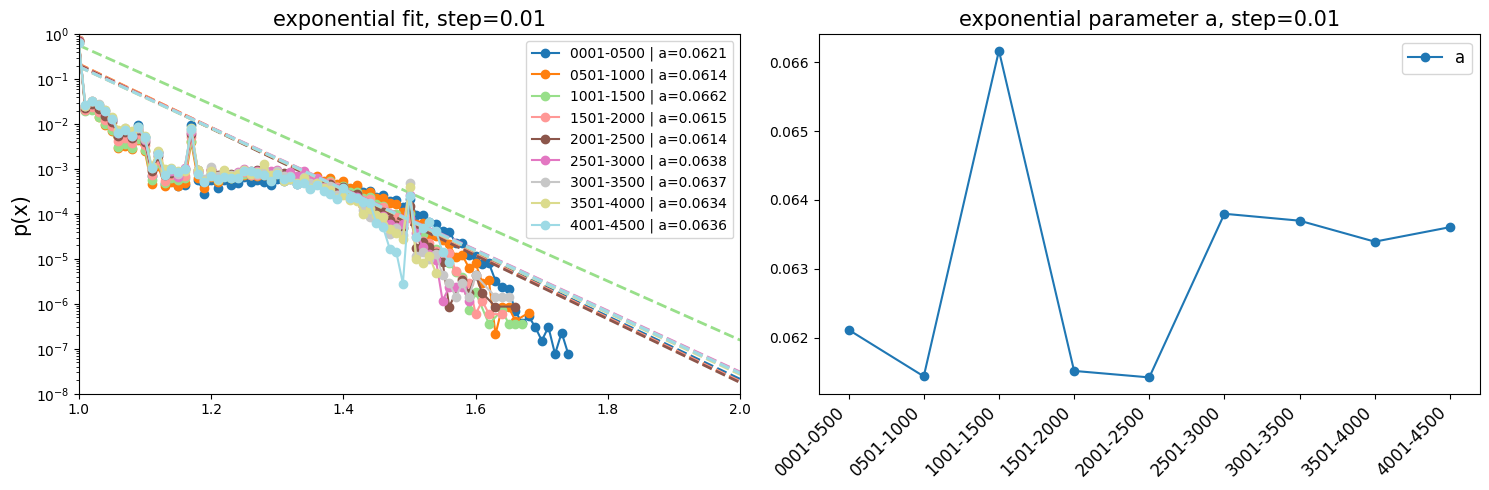

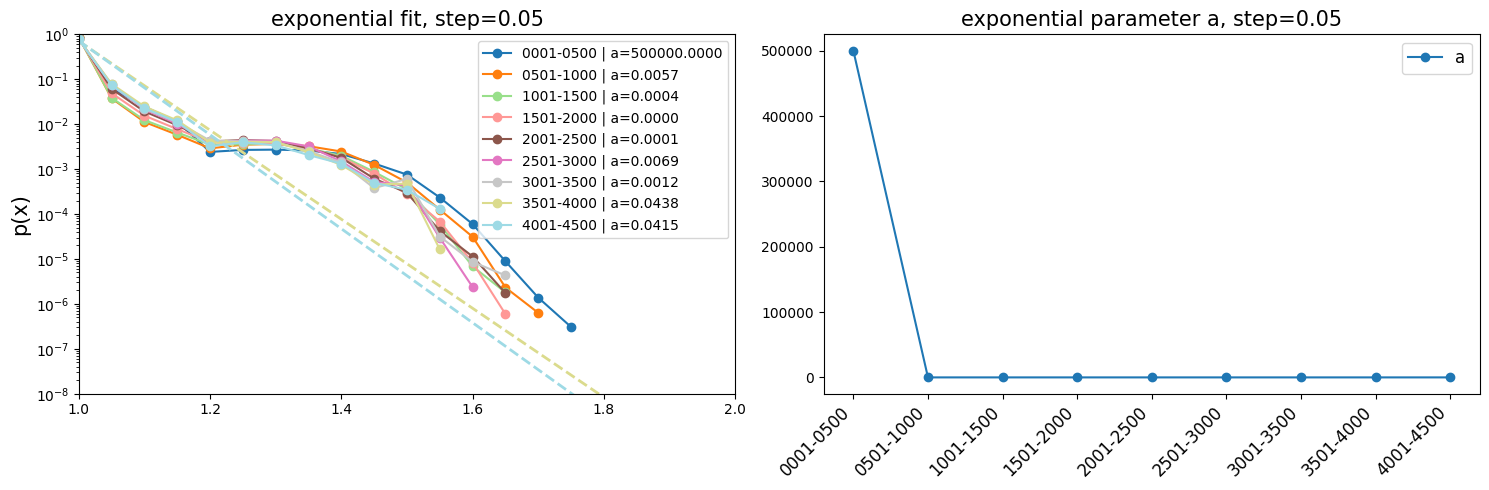

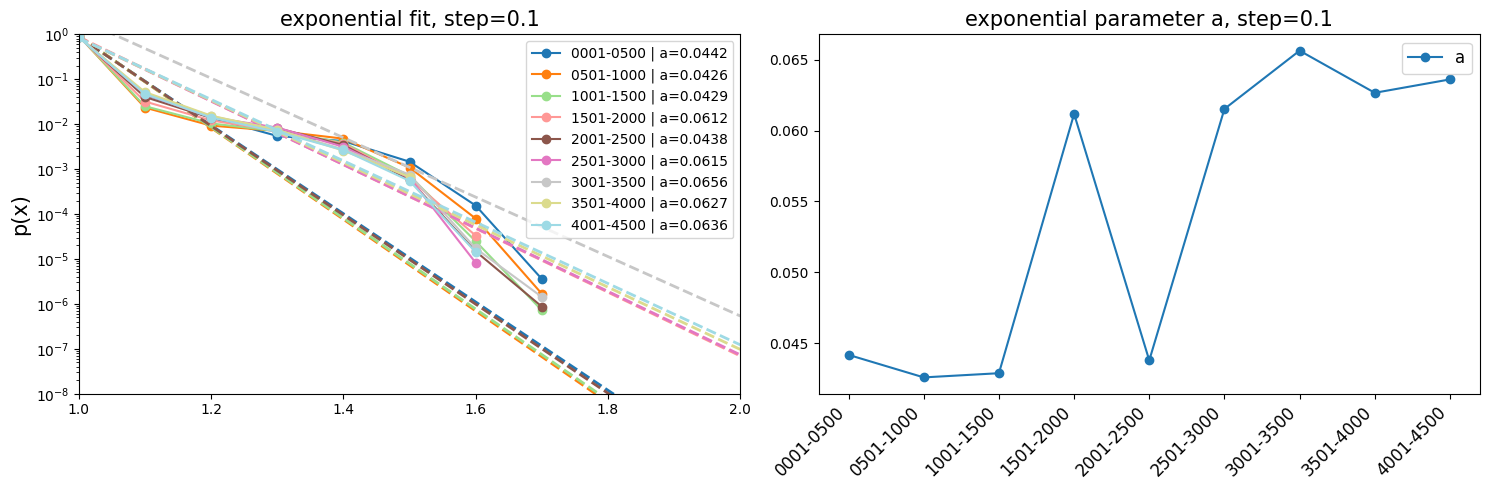

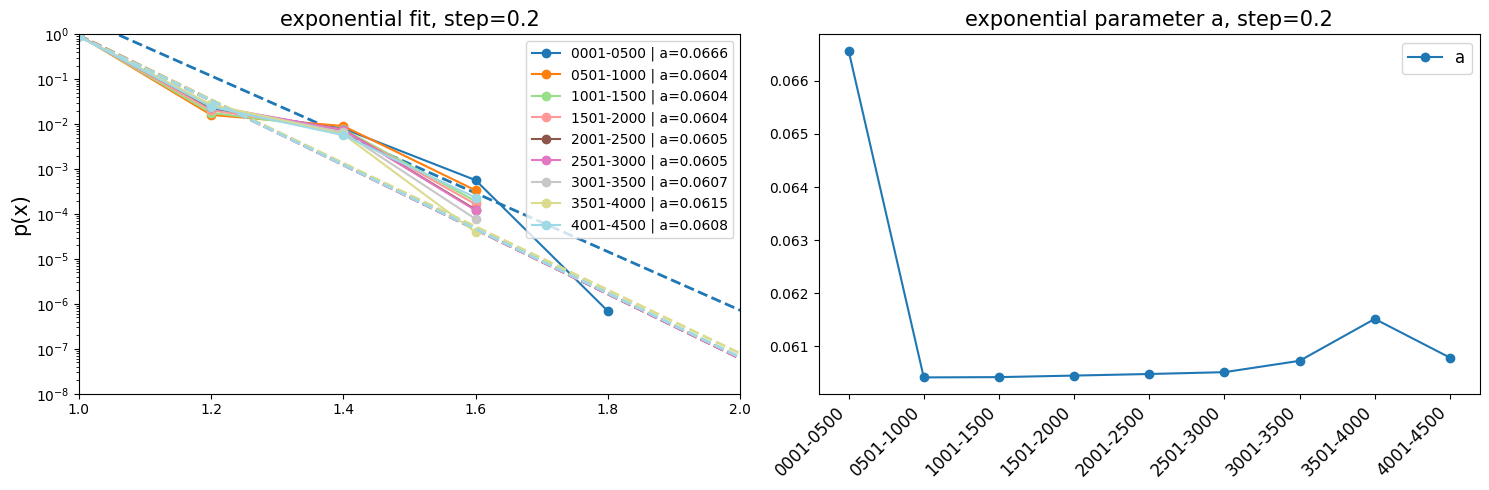

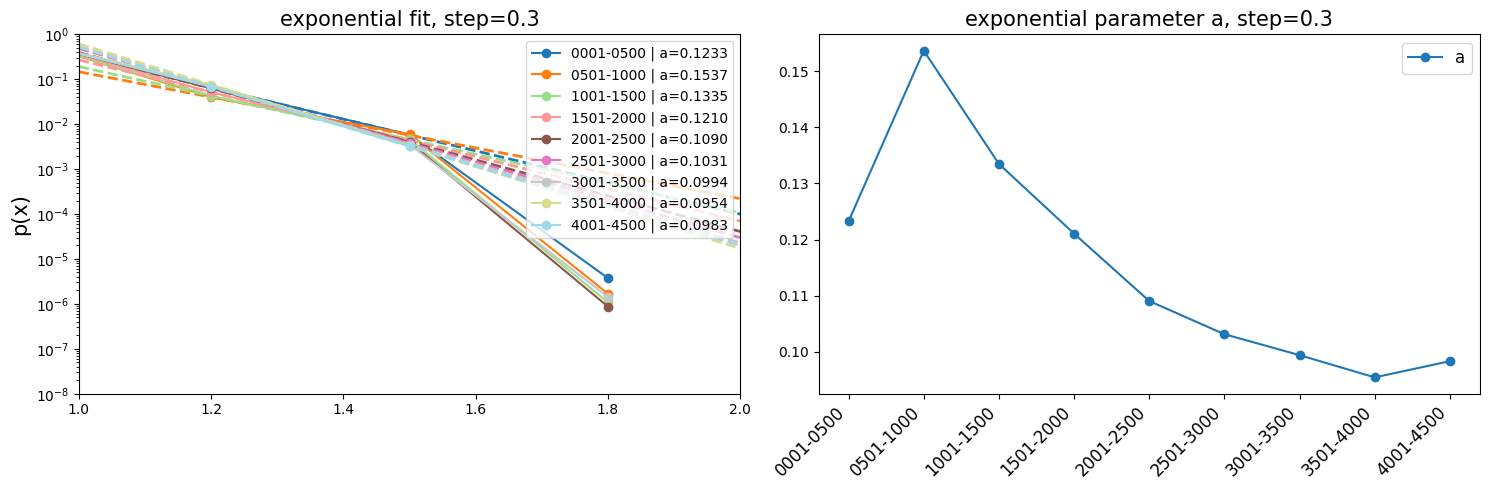

In [35]:
# Use Parquet generated by the fractal-dimension extraction cell
in_path = Path("fractals_results_full.parquet")

table = pq.read_table(in_path)
data = table.to_pydict()

n = len(data["group_label"])
groups = [{k: data[k][i] for k in data.keys()} for i in range(n)]
group_labels = [g["group_label"] for g in groups]

# bin size for stats_preprocess
for step in tqdm([0.01, 0.05, 0.1, 0.2, 0.3]):

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Colors per group (will cycle if many groups)
    colors = plt.cm.tab20(np.linspace(0, 1, max(2, min(20, len(groups)))))

    a_list = []

    for idx, g in enumerate(groups):
        fd_list = g.get("fd_list", [])
        if fd_list is None:
            fd_list = []
        else:
            fd_list = list(fd_list)

        color = colors[idx % len(colors)]

        if not fd_list:
            a_list.append(np.nan)
            continue

        x_orig, y_orig = cstats.stats_preprocess(fd_list, step)

        # Exponential distribution only
        (x_fit, y_fit), a, amp_exp = capprox.exponential_approx(
            x_orig, y_orig, a=1, amp=1, x_lim=[1, 2], N=20
        )
        a_list.append(a)

        label = (
            # f"{g['group_label']} | imgs={g.get('n_images', 0)} | cnts={g.get('n_contours', 0)} | a={a:.4f}"
            f"{g['group_label']} | a={a:.4f}"
        )

        axes[0].plot(x_fit, y_fit, '--', linewidth=2, color=color)
        axes[0].plot(x_orig, y_orig, '-o', color=color, label=label)

    axes[0].set_title(f'exponential fit, step={step}', fontsize=15)
    axes[0].set_xlim(1, 2)
    axes[0].set_ylim(1e-8, 1)
    axes[0].set_yscale('log')
    axes[0].set_ylabel('p(x)', fontsize=15)
    axes[0].legend(loc='upper right', fontsize=10)

    # Diagnostics: parameter a per group
    axes[1].plot(range(len(groups)), a_list, '-o', label='a')
    axes[1].set_title(f'exponential parameter a, step={step}', fontsize=15)
    axes[1].set_xticks(range(len(groups)))
    axes[1].set_xticklabels(group_labels, rotation=45, fontsize=12, ha='right')
    axes[1].legend(loc='upper right', fontsize=12)

    plt.tight_layout()
    plt.show()
